# E5 - Grupo 5

# 0. Cargue de datos

In [41]:
import pandas as pd
%matplotlib inline

df = pd.read_csv('example_retail_sales.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [42]:
df.tail()

,ds,y
288,2016-01-01,400928
289,2016-02-01,413554
290,2016-03-01,460093
291,2016-04-01,450935
292,2016-05-01,471421


Un primer análisis general sugiere que se tiene una serie de tiempo que consta de 292 observaciones correspondientes a los registros mensuales de ventas desde enero de 1992 hasta mayo de 2016.

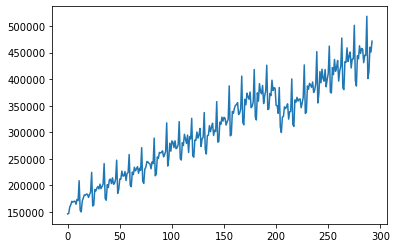

In [43]:
df['y'].plot()

El gráfico plot de las ventas a lo largo del tiempo muestra una tendencia creciente que inicia con uan pendiente y que tiene un ligero aumento de esta a partir del año 2005 y con un cambio importante a partir del año 2008 en el que se presenta una reducción de las ventas. Gráficamente parece tenerse un comportamiento estacional cada doce meses, son el mayor número mensual de ventas cada año en el mes de diciembre, esta estacionalidad no se ve afectada por el cambiode niveles de ventas mencionado.

# 1. Estandarización de los datos

Para estandarizar los datos de ventas, utilizamos np.log de la libraría numpy, contruyendo un nuevo dataset que procederemos a explorar.

In [64]:
import numpy as np

df1 = pd.DataFrame()
df1['ds'] = pd.to_datetime(df['ds'])
df1['y']=np.log(df['y'])
df1.head()

,ds,y
0,1992-01-01,11.893934
1,1992-02-01,11.898725
2,1992-03-01,11.978770
3,1992-04-01,12.005601
4,1992-05-01,12.043954


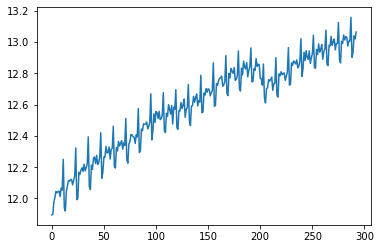

In [65]:
df1['y'].plot()

La gráfica con los datos estandarizados, es decir los datos resultantes de tranformar la variable ventas original con la funcion logaritmo natural, nos muestra las mismas características de estacionalidad por cada vigencia y los cambios abruptos, disminución de los niveles de ventas, a partir del año 2008.

# 2. Predicción logarítmo de ventas

In [66]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Creamos el marco de datos de la predicción que incluya los datos históricos y 6 meses adicionales de predicción 

In [67]:
m1 = Prophet()
m1.fit(df1)

future1 = m1.make_future_dataframe(periods=6, freq='m')
future1.tail(6)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
293,2016-05-31
294,2016-06-30
295,2016-07-31
296,2016-08-31
297,2016-09-30
298,2016-10-31


El método predict nos permite asignar a cada fila del marco de datos creado un valor de predicción yhat y adicolamnete las columnas con los intervalos de incertidumbre.

In [68]:
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
293,2016-05-31,13.057727,13.036182,13.078232
294,2016-06-30,13.057700,13.038176,13.078008
295,2016-07-31,13.082357,13.062241,13.102596
296,2016-08-31,13.015546,12.994432,13.034299
297,2016-09-30,13.037862,13.016538,13.058343
298,2016-10-31,13.055691,13.033800,13.078023


Graficamos el pronóstico, obteniendo visualmente al parecer un buen modelo ajustado.

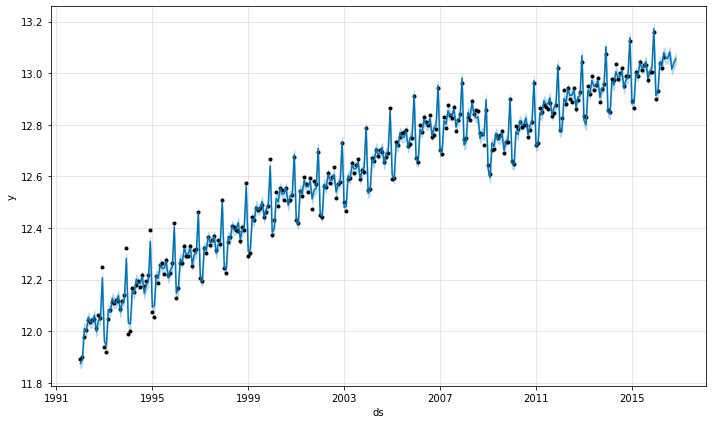

In [69]:
fig1 = m1.plot(forecast1)

Ahora se muestran los componentes de la previsión que reflejan en la tendencia un cambio importante a partir de 2008 al disminuis el nivel de ventas sin dejar de tener tendencia positiva en los siguientes años. Por otra parte, el análisis de la tendencia mensual permite determinar que los niveles de ventas presentan una caida importante hacia los meses de febrero, recuperándose en el mes de marzo donde posteriomente con tendencia levemente decreciento, hasta el mes de septiembre, en el que la tendencia vuelve a ser positva y se logra el mayor nivel de ventas del año en el mes de diciembre.


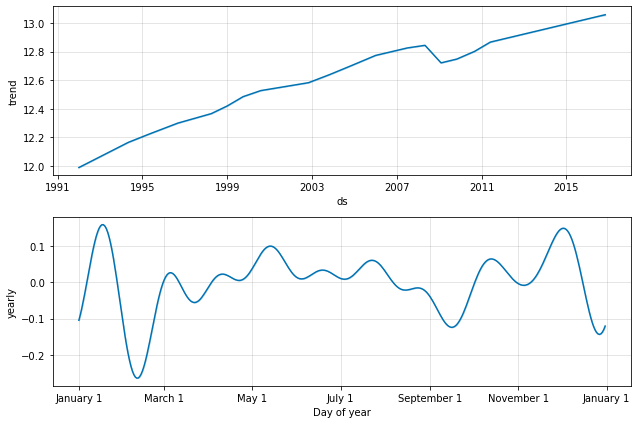

In [70]:
m1.plot_components(forecast1);

Ahora, la evaluación del desempeño de las predicciones usando la función cross_validation se muestra a continuación: 

In [71]:
from fbprophet.diagnostics import cross_validation

data_cv1 = cross_validation(m1, initial='730 days', period='180 days', horizon='365 days')

INFO:fbprophet:Making 44 forecasts with cutoffs between 1994-02-21 00:00:00 and 2015-05-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [72]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

performance_metrics(data_cv1)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,38 days,0.001031,0.032104,0.024915,0.001960,0.001914,0.442308
1,39 days,0.001103,0.033206,0.025644,0.002017,0.001914,0.461538
2,40 days,0.001130,0.033608,0.026055,0.002051,0.001916,0.442308
3,42 days,0.001140,0.033767,0.026243,0.002066,0.001919,0.442308
4,43 days,0.001218,0.034893,0.027054,0.002131,0.001919,0.435897
...,...,...,...,...,...,...,...
266,361 days,0.005090,0.071347,0.053269,0.004190,0.002699,0.403846
267,362 days,0.005112,0.071498,0.054118,0.004255,0.002699,0.391026
268,363 days,0.004864,0.069745,0.053612,0.004215,0.002956,0.365385
269,364 days,0.004307,0.065629,0.050426,0.003965,0.002767,0.384615


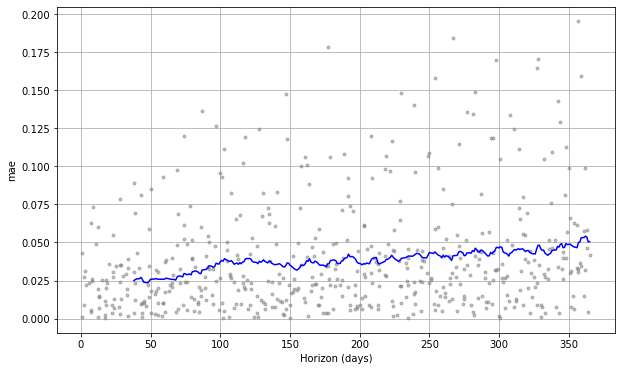

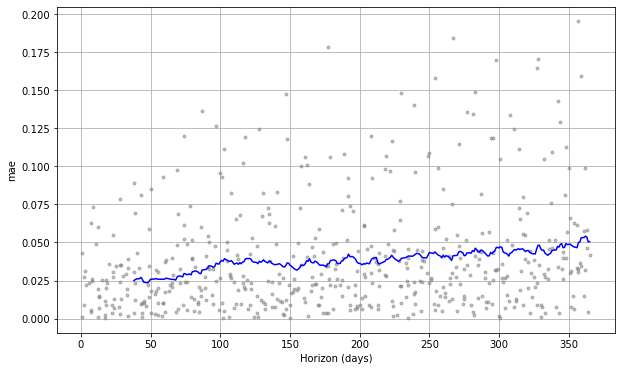

In [73]:
plot_cross_validation_metric(data_cv1, metric='mae')

# 3. Predicción de ventas

In [49]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Creamos el marco de datos de la predicción que incluya los datos históricos y 6 meses adicionales de predicción 

In [52]:
m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=6, freq='m')
future.tail(6)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
293,2016-05-31
294,2016-06-30
295,2016-07-31
296,2016-08-31
297,2016-09-30
298,2016-10-31


El método predict nos permite asignar a cada fila del marco de datos creado un valor de predicción yhat y adicolamnete las columnas con los intervalos de incertidumbre.

In [54]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
293,2016-05-31,469086.526173,459238.672400,479223.243751
294,2016-06-30,470389.489767,459338.607562,480706.978262
295,2016-07-31,477462.506058,466799.199174,487530.100021
296,2016-08-31,454508.224157,444136.056380,465923.037437
297,2016-09-30,462881.112019,452527.609982,473615.613344
298,2016-10-31,468472.871196,458945.420293,479208.360212


Graficamos el pronóstico, obteniendo visualmente al parecer un buen modelo ajustado.

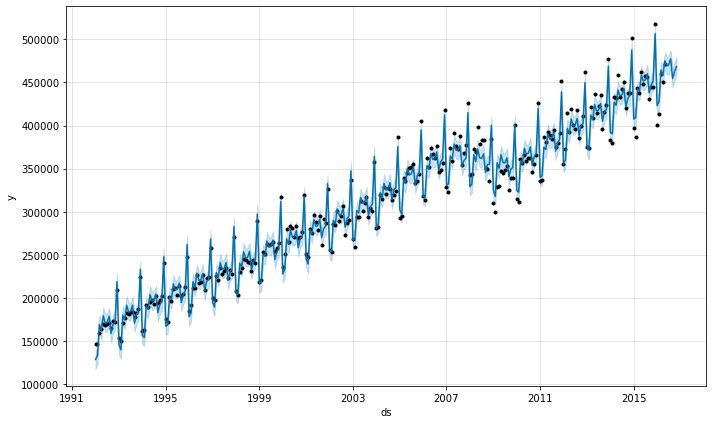

In [55]:
fig2 = m.plot(forecast)

Ahora se muestran los componentes de la previsión que reflejan en la tendencia un cambio importante a partir de 2008 al disminuis el nivel de ventas sin dejar de tener tendencia positiva en los siguientes años. Por otra parte, el análisis de la tendencia mensual permite determinar que los niveles de ventas presentan una caida importante hacia los meses de febrero, recuperándose en el mes de marzo donde posteriomente con tendencia levemente decreciento, hasta el mes de septiembre, en el que la tendencia vuelve a ser positva y se logra el mayor nivel de ventas del año en el mes de diciembre.


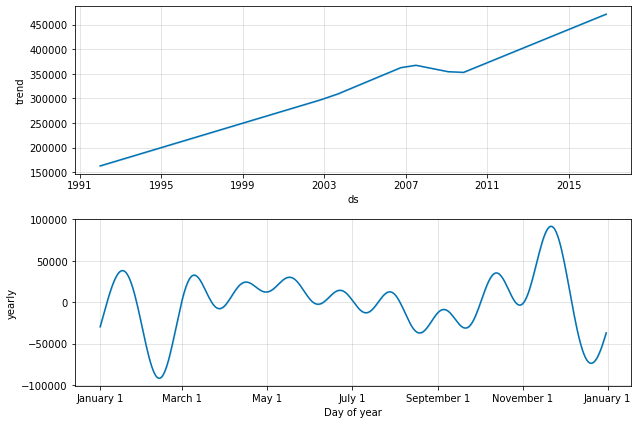

In [32]:
m.plot_components(forecast);

Ahora, la evaluación del desempeño de las predicciones usando la función cross_validation se muestra a continuación: 

In [60]:
from fbprophet.diagnostics import cross_validation

data_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')

INFO:fbprophet:Making 44 forecasts with cutoffs between 1994-02-21 00:00:00 and 2015-05-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [61]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

performance_metrics(data_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,38 days,1.803994e+08,13431.283488,9454.179289,0.028347,0.019476,0.423077
1,39 days,1.889343e+08,13745.337823,9674.400935,0.028733,0.019476,0.423077
2,40 days,1.910997e+08,13823.883196,9801.993488,0.029268,0.022534,0.403846
3,42 days,1.911794e+08,13826.763841,9836.583630,0.029445,0.022534,0.384615
4,43 days,1.828305e+08,13521.482437,9774.543463,0.029446,0.022534,0.371795
...,...,...,...,...,...,...,...
266,361 days,6.371015e+08,25240.870531,17564.168628,0.050015,0.030555,0.326923
267,362 days,6.315943e+08,25131.540412,17852.008823,0.050719,0.030555,0.294872
268,363 days,5.950675e+08,24394.004927,17701.038222,0.050088,0.032503,0.269231
269,364 days,5.225571e+08,22859.508268,16694.269909,0.047177,0.031589,0.288462


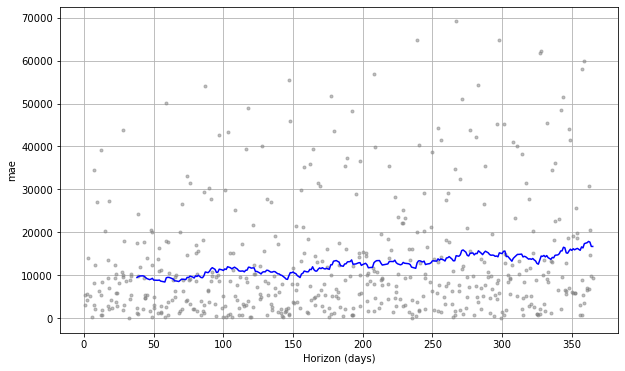

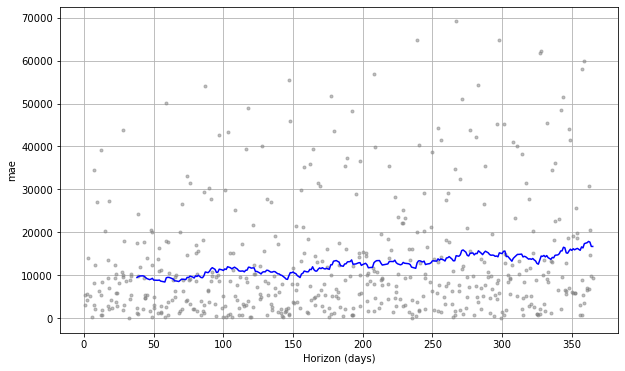

In [62]:
plot_cross_validation_metric(data_cv, metric='mae')

# 4. Conclusión
